# 데이터 분할

1. 학습파트 <br>
학습 : 2017 2018 2019
<br>라벨 : 2020

2. 테스트파트 <br>
예측 : 2018 2019 2020
<br>검증 : 2021

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
from tqdm import tqdm

print ('Current cuda device ', torch.cuda.current_device())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.get_device_name(device))

Current cuda device  0
Tesla K80


In [ ]:
corpus_num = 22685 # Dict에 속한 단어 개수
topic_num = 50 # Dtm에서 잡은 topic의 개수
train_input = np.empty((0, corpus_num))
train_label = np.empty((0, corpus_num))
test_input = np.empty((0, corpus_num))
test_label = np.empty((0, corpus_num))
predict_input = np.empty((0, corpus_num))

for index in range(topic_num):
    dtm_result = pd.read_excel("topic" + str(index+1) + "_dtm.xlsx") # 각 토픽별로 엑세 파일 불러옴

    # 학습파트 train, label 생성
    for i in range(2017, 2020):
        train_input = np.append(train_input, np.reshape((dtm_result[i] * 1500).to_numpy(), (1, corpus_num)), axis = 0)
    train_label = np.append(train_label, np.reshape((dtm_result[2020] * 1500).to_numpy(), (1, corpus_num)), axis = 0)
    
    # 검증파트 train, label 생성
    for j in range(2018, 2021):
        test_input = np.append(test_input, np.reshape((dtm_result[j] * 1500).to_numpy(), (1, corpus_num)), axis = 0)
    test_label = np.append(test_label, np.reshape((dtm_result[2021] * 1500).to_numpy(), (1, corpus_num)), axis = 0)

    # 예측파트 input 생성
    for j in range(2019, 2022):
      predict_input = np.append(predict_input, np.reshape((dtm_result[j] * 1500).to_numpy(), (1, corpus_num)), axis = 0)


# topic 단위로 찢음
train_input = np.reshape(train_input, (topic_num, 3, corpus_num))
train_label = np.reshape(train_label, (topic_num, corpus_num))
test_input = np.reshape(test_input, (topic_num, 3, corpus_num))
test_label = np.reshape(test_label, (topic_num, corpus_num))
predict_input = np.reshape(predict_input, (topic_num, 3, corpus_num))

# Pytorch tensor로 변환
train_input = Variable(torch.Tensor(train_input)).to(device)
train_label = Variable(torch.Tensor(train_label)).to(device)
test_input = Variable(torch.Tensor(test_input)).to(device)
test_label = Variable(torch.Tensor(test_label)).to(device)
predict_input = Variable(torch.Tensor(predict_input)).to(device)

In [ ]:
train_input.shape, test_input.shape, train_label.shape, test_label.shape, predict_input.shape

(torch.Size([50, 3, 22685]),
 torch.Size([50, 3, 22685]),
 torch.Size([50, 22685]),
 torch.Size([50, 22685]),
 torch.Size([50, 3, 22685]))

# LSTM

## Hyperparameter

In [ ]:
seq_length = 3 #3년치가 LSTM으로 들어가는 상황이므로
hidden_dim = 3 #number of features in hidden state
num_layers = 2 #number of stacked lstm layers
num_epochs = 1500 #1500 epochs
learning_rate = 0.002 #0.002 lr
decay = 0.02
input_dim = corpus_num #number of features
output_dim = corpus_num

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, seq_length, batch_size = 50, drop_prob=0.2):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.seq_length = seq_length
        self.batch_size = batch_size 
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=drop_prob, bidirectional=False)
        self.fc = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.LeakyReLU(0.1) # LeakyReLU로 변경
        self.bn = nn.BatchNorm1d(hidden_dim)
        
    def forward(self, x):
        h0 = Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim)).to(device) 
        c0 = Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim)).to(device)
        x = x.to(device)
        out, (h_n,c_n) = self.lstm(x, (h0,c0))
        out = out[:, -1, :] # 맨 마지막 추론 결과만 받음
        out = self.bn(out)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc_out(out)
        return out, h_n

## Train

In [ ]:
lstm = LSTM(input_dim, hidden_dim, output_dim, num_layers, seq_length).to(device) 
criterion = nn.MSELoss()  # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate, amsgrad=True)

In [ ]:
train_loss = []
val_loss = [] 

for epoch in tqdm(range(num_epochs)):
      lstm.train()
      outputs, h_out = lstm(train_input.to(device))
      optimizer.zero_grad()
      loss = criterion(outputs, train_label.to(device))
      train_loss.append(loss.item())
      loss.backward()
      optimizer.step()
      if epoch % 100 == 0:
          print("Train loss: %1.5f"%(loss.item()))
      
      with torch.no_grad():
          lstm.eval()
          output, h_out = lstm(test_input.to(device))
          Loss = criterion(output, test_label.to(device))
          predicted = output.cpu()
          val_loss.append(Loss.item())
          if epoch % 100 == 0:
            print("Val loss: %1.5f"%(Loss.item()))
print("Fin.")

  2%|▏         | 24/1500 [00:00<00:12, 115.71it/s]

Train loss: 1.93164
Val loss: 1.93381


  8%|▊         | 118/1500 [00:01<00:12, 110.05it/s]

Train loss: 1.77164
Val loss: 1.78140


 14%|█▍        | 214/1500 [00:01<00:11, 112.93it/s]

Train loss: 1.72500
Val loss: 1.73498


 21%|██▏       | 322/1500 [00:02<00:10, 111.94it/s]

Train loss: 1.69590
Val loss: 1.70608


 28%|██▊       | 418/1500 [00:03<00:09, 113.04it/s]

Train loss: 1.66186
Val loss: 1.67210


 34%|███▍      | 514/1500 [00:04<00:08, 110.93it/s]

Train loss: 1.62562
Val loss: 1.63465


 41%|████▏     | 622/1500 [00:05<00:07, 112.77it/s]

Train loss: 1.61136
Val loss: 1.62194


 48%|████▊     | 718/1500 [00:06<00:07, 111.59it/s]

Train loss: 1.60768
Val loss: 1.61762


 54%|█████▍    | 814/1500 [00:07<00:06, 110.28it/s]

Train loss: 1.60737
Val loss: 1.61611


 61%|██████▏   | 922/1500 [00:08<00:05, 111.78it/s]

Train loss: 1.60314
Val loss: 1.61348


 68%|██████▊   | 1018/1500 [00:09<00:04, 111.85it/s]

Train loss: 1.60065
Val loss: 1.61013


 74%|███████▍  | 1114/1500 [00:09<00:03, 114.75it/s]

Train loss: 1.59658
Val loss: 1.60874


 81%|████████▏ | 1222/1500 [00:10<00:02, 111.90it/s]

Train loss: 1.59773
Val loss: 1.60572


 88%|████████▊ | 1318/1500 [00:11<00:01, 112.58it/s]

Train loss: 1.59414
Val loss: 1.60414


 94%|█████████▍| 1414/1500 [00:12<00:00, 112.95it/s]

Train loss: 1.59363
Val loss: 1.60419


100%|██████████| 1500/1500 [00:13<00:00, 111.84it/s]

Fin.


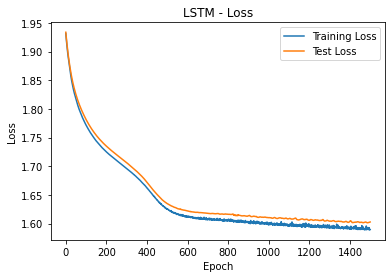

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(len(train_loss)), train_loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM - Loss')
plt.show()

In [ ]:
from scipy import stats
test_label = test_label.cpu()

cor = 0
spearman_top = [] # spearman cor 순서대로 저장
for index in range(50):
  predict = predicted[index]
  answer = test_label[index]

  result = stats.spearmanr(predict, answer)
  cor += result[0]
  spearman_top.append((result[0], index))
  print(result)

spearman_top.sort(reverse = True)

print("------------------------------------------------------------")
print("Spearmanr correlation mean value :", cor / 50)

SpearmanrResult(correlation=0.31792789576361696, pvalue=0.0)
SpearmanrResult(correlation=0.3215945482246408, pvalue=0.0)
SpearmanrResult(correlation=0.2953161855434889, pvalue=0.0)
SpearmanrResult(correlation=0.3318199023779409, pvalue=0.0)
SpearmanrResult(correlation=0.3238293045401045, pvalue=0.0)
SpearmanrResult(correlation=0.20723309539045562, pvalue=1.5854462349694405e-218)
SpearmanrResult(correlation=0.3204800045026278, pvalue=0.0)
SpearmanrResult(correlation=0.2665877808910823, pvalue=0.0)
SpearmanrResult(correlation=0.33963977576539617, pvalue=0.0)
SpearmanrResult(correlation=0.3192075945966125, pvalue=0.0)
SpearmanrResult(correlation=0.321604664080177, pvalue=0.0)
SpearmanrResult(correlation=0.3130237829786317, pvalue=0.0)
SpearmanrResult(correlation=0.1939971062053711, pvalue=3.0549011761388174e-191)
SpearmanrResult(correlation=0.31826542876400676, pvalue=0.0)
SpearmanrResult(correlation=0.29336922842071456, pvalue=0.0)
SpearmanrResult(correlation=0.30143344939633393, pvalue=

## 2022 키워드 추출
토픽 몇 개만 선정해서,

해당 토픽에서 가장 스코어 높은 키워드 상위 10개 정도만 추출 -> 2019, 2020, 2021 input으로 2022예측

In [ ]:
import copy
import random
excel_temp = pd.read_excel("topic" + str(1) + "_dtm.xlsx", names = ['name', 2017, 2018, 2019, 2020, 2021])
keyword = excel_temp['name']

lstm.eval()
with torch.no_grad():
  predict = lstm(predict_input)

predict = predict[0].tolist()
predict_result = []

for i in range(50):
  index = spearman_top[i][1]
  val = copy.copy(predict[index])
  val.sort(reverse = True)
  val = val[50:55]
  temp = []
  for j in range(5):
    keyword_index = predict[index].index(val[j])
    temp.append(keyword[keyword_index])
  predict_result.append(temp)

predict_result = list(set([tuple(set(item)) for item in predict_result])) # 중복 제거

predict_result = np.array(predict_result)

In [ ]:
predict_result

array([['classification', 'representations', 'order', 'expression',
        'boundaries'],
       ['approaches', 'structure', 'input', 'sequence', 'techniques'],
       ['point', 'structure', 'bias', 'architecture', 'frequency'],
       ['applications', 'input', 'functions', 'set', 'sequence'],
       ['wave', 'Markov', 'degradation', 'Vision', 'representation'],
       ['wave', 'GANs', 'work', 'codes', 'degradation'],
       ['representations', 'approaches', 'point', 'expression', 'graph'],
       ['applications', 'input', 'functions', 'sequence', 'techniques'],
       ['number', 'scene', 'structure', 'input', 'techniques'],
       ['number', 'scene', 'input', 'functions', 'techniques']],
      dtype='<U15')